# Exporting Data to Pardiso (Modular Backend) and Calculating Band Structure

This tutorial demonstrates the **new modular backend** for Pardiso integration in DeePTB.
It uses:
1. `to_pardiso_new` method: Exports data in an optimized JSON + HDF5 format.
2. Modular Julia Backend (`main.jl`): A structured, extensible Julia codebase for calculations.

## Objectives
1. Initialize a `TBSystem`.
2. Export data using the optimized `to_pardiso_new`.
3. Run the modular Julia script (`main.jl`) to calculate band structure.
4. Visualize results.

## 1. Setup Paths

Define paths to model, structure, and the NEW output directory.

In [1]:
import os
import shutil
import torch
import numpy as np
import subprocess
import sys
import json

# Ensure dptb is in path
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))
from dptb.postprocess.unified.system import TBSystem

root_dir = os.path.dirname(os.path.abspath("__file__")) 
# Note: In Jupyter __file__ might not exist, using current dir if needed
if not os.path.exists(root_dir) or root_dir == '':
    root_dir = os.getcwd()

model_path = os.path.join(root_dir,  "nnsk.iter_ovp0.000.pth")
struct_path = os.path.join(root_dir, "min.vasp")
output_dir = os.path.join(root_dir, "output_new_notebook")
julia_out_dir = os.path.join(output_dir, "julia_results")

print(f"Root Dir: {root_dir}")
print(f"Output Dir: {output_dir}")

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
Pybinding is not installed. Please install it via `pip install pybinding`


Root Dir: /root/soft/DeePTB/examples/To_pardiso
Output Dir: /root/soft/DeePTB/examples/To_pardiso/output_new_notebook


## 2. Initialize TBSystem

Load structure and model.

In [2]:
tbsys = TBSystem(data=struct_path, calculator=model_path)
print("TBSystem initialized successfully.")
print(f"System Info: {tbsys.atoms}")

TBSystem initialized successfully.
System Info: Atoms(symbols='C84', pbc=True, cell=[93.478815071, 28.220313831, 4.26])


## 3. Export Data (New Method)

We use `to_pardiso_new` which generates:
- `structure.json`: All structure info (replacing 4 text files).
- `predicted_hamiltonians.h5`
- `predicted_overlaps.h5`

In [3]:
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

# Call the new export method
tbsys.to_pardiso_new(output_dir=output_dir)

print(f"Data exported to {output_dir}")
print("Generated files:")
for f in sorted(os.listdir(output_dir)):
    print(f" - {f}")

Data exported to /root/soft/DeePTB/examples/To_pardiso/output_new_notebook
Generated files:
 - predicted_hamiltonians.h5
 - predicted_overlaps.h5
 - structure.json


## 4. Run Modular Julia Backend

We call `dptb/postprocess/julia/main.jl`. This script handles input loading, solver selection, and task execution.

In [2]:
parent_path = os.path.dirname(os.path.dirname(os.getcwd()))
julia_script = os.path.join(parent_path, "dptb/postprocess/julia/main.jl")
config_path = os.path.join(root_dir, "band.json")

if not os.path.exists(julia_out_dir):
    os.makedirs(julia_out_dir)

cmd = [
    "julia",
    julia_script,
    "--input_dir", output_dir,
    "--output_dir", julia_out_dir,
    "--config", config_path
]

print(f"Running Command: {' '.join(cmd)}")

try:
    result = subprocess.run(cmd, capture_output=True, text=True, check=True)
    print("\nJulia Output:")
    print(result.stdout)
    print("Julia Execution Successful!")
except subprocess.CalledProcessError as e:
    print("Julia script failed with error:")
    print(e.stderr)

Running Command: julia /root/soft/DeePTB/dptb/postprocess/julia/main.jl --input_dir /root/soft/DeePTB/examples/To_pardiso/output_new_notebook --output_dir /root/soft/DeePTB/examples/To_pardiso/output_new_notebook/julia_results --config /root/soft/DeePTB/examples/To_pardiso/band.json

Julia Output:
Loading H/S matrices from cache: /root/soft/DeePTB/examples/To_pardiso/output_new_notebook/sparse_matrices.jld
Task finished. Total time: 0.66 min

Julia Execution Successful!


## 5. Visualizing Results

Load `bandstructure.h5` generated by the Julia backend.

Loading results from /root/soft/DeePTB/examples/To_pardiso/output_new_notebook/julia_results/bandstructure.h5...
Successfully loaded bandstructure.h5
Eigenvalues shape: (101, 30)


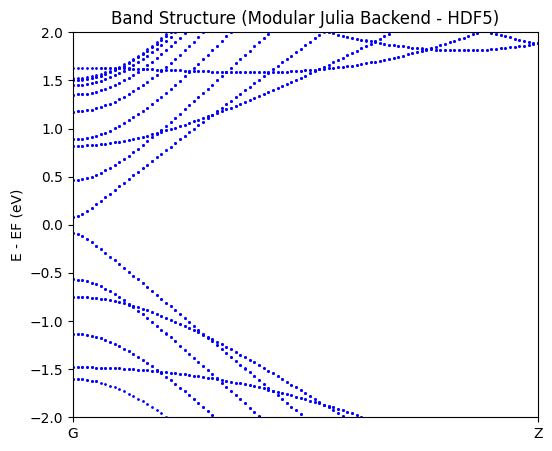

In [7]:
expected_h5 = os.path.join(julia_out_dir, "bandstructure.h5")
import h5py

print(f"Loading results from {expected_h5}...")
with h5py.File(expected_h5, 'r') as f:
    evals = f['eigenvalues'][:]
    x = f['xlist'][:]
    e_fermi = f['E_fermi'][()]
    high_sym_kpoints = f['high_sym_kpoints'][:]
    labels_bytes = f['labels'][:]
    
# Decode labels from bytes to string
try:
    labels = [l.decode('utf-8') for l in labels_bytes]
except AttributeError:
    # If already strings (depending on HDF5 version/julia writing), keep as is
    labels = list(labels_bytes)


print(f"Successfully loaded bandstructure.h5")
print(f"Eigenvalues shape: {evals.shape}")

import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))

evals_shifted = evals - e_fermi
for i in range(evals.shape[1]): # Loop over bands (rows in Julia hcat)
    plt.scatter(x, evals_shifted[:, i], s=1, c='blue') 
    
plt.xticks(high_sym_kpoints, labels)
plt.xlim(0,x[-1])
plt.ylim(-2,2)
plt.ylabel('E - EF (eV)')
plt.title('Band Structure (Modular Julia Backend - HDF5)')
plt.show()